In [1]:
# LIBRARIES
from pandas import Series,DataFrame
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [2]:
# DATA MANAGEMENT
data = pd.read_csv('dataset/training.csv')

In [3]:
# upper case all DataFrame column names
data.columns = map(str.upper, data.columns)

In [4]:
# clean data
data_cleaned = data.dropna()

In [5]:
# subset clustering variables
cluster = data_cleaned[['VEHICLEAGE','VEHODO']]
cluster.describe()

,VEHICLEAGE,VEHODO
count,3276.000000,3276.000000
mean,4.592186,77494.626984
std,1.869413,15090.185027
min,1.000000,19610.000000
25%,3.000000,68354.500000
50%,4.000000,78546.500000
75%,6.000000,87997.500000
max,9.000000,115026.000000


In [6]:
# standardize clustering variables (normalization)
clustervar = cluster.copy()
clustervar['VEHICLEAGE'] = preprocessing.scale(clustervar['VEHICLEAGE'].astype('float64'))
clustervar['VEHODO'] = preprocessing.scale(clustervar['VEHODO'].astype('float64'))

In [7]:
# split data into train and test sets
clus_train, clus_test = train_test_split(clustervar, test_size=.3, random_state=123)

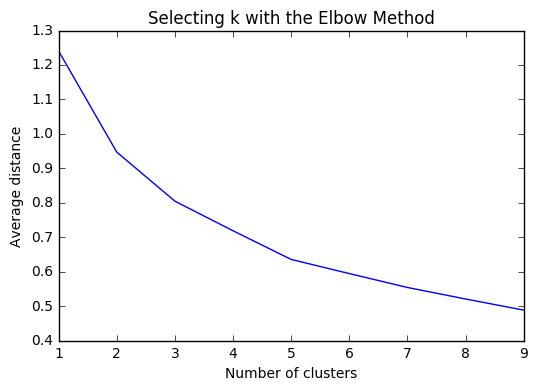

In [8]:
# k-means cluster analysis for 1-9 clusters
from scipy.spatial.distance import cdist

clusters = range(1,10)
meandist = []

for k in clusters:
    model = KMeans(n_clusters= k)
    model.fit(clus_train)
    clusassign = model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1))
    / clus_train.shape[0])

plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')
plt.show()

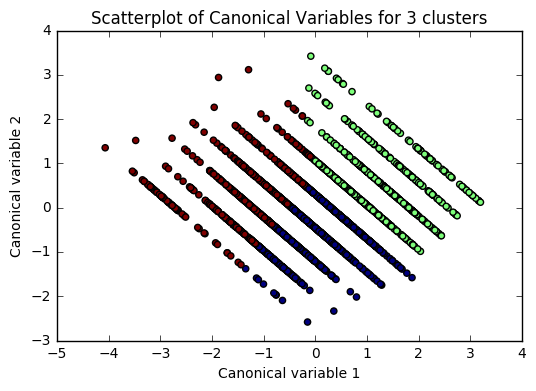

In [9]:
# interpret 3 cluster solutions
model3 = KMeans(n_clusters=3)
model3.fit(clus_train)
clusassign = model3.predict(clus_train)

# Canonical Discriminant Analysis
# Creates a smaller number of variables
# Linear combinations of clustering variables
# Canonical variables are ordered by proportion of variance accounted for
# Majority of variance is accounted for by first few canonical variables
from sklearn.decomposition import PCA
pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)
plt.scatter(x = plot_columns[:,0], y = plot_columns[:,1], c = model3.labels_)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 3 clusters')
plt.show()

In [10]:
# Begin multiple steps to merge cluster assignment with clustering variables to examine
# cluster variable means by cluster

# create unique identifier variable from the index for
# the cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level=0, inplace=True)

# create a list that has the new index variable
cluslist = list(clus_train['index'])

# create a list of cluster assignments
labels = list(model3.labels_)

# combine index variable list with cluster assignment list into a dictionary
newlist = dict(zip(cluslist, labels))

# convert newlist dictionary to a dataframe
newclus = DataFrame.from_dict(newlist, orient='index')

# now do the same for the cluster assignment variable
# rename the cluster assignment column
newclus.columns = ['cluster']

# create a unique identifier variable from the index for the cluster assignment dataframe
# to merge with cluster training data
newclus.reset_index(level=0, inplace=True)

# merge the cluster assignment dataframe with the cluster training variable dataframe by
# the index variable
merged_train = pd.merge(clus_train, newclus, on='index')
merged_train.head(n=100)

# cluster frequencies
merged_train.cluster.value_counts()

0    1007
2     646
1     640
Name: cluster, dtype: int64

In [11]:
# Finally calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print('Clustering variable means by cluster')
print(clustergrp)

Clustering variable means by cluster
                index  VEHICLEAGE    VEHODO
cluster                                    
0        35022.323734   -0.356140  0.445530
1        35321.967187    1.262288  0.464303
2        34726.174923   -0.670460 -1.186602


In [14]:
# Validate cluster in training data by examining cluster differences in IsBadBuy using ANOVA
# first have to merge IsBadBuy with clustering variables and cluster assignment data
gpa_data = data_cleaned['ISBADBUY']
# split GPA data into train and test sets
gpa_train, gpa_test = train_test_split(gpa_data, test_size=.3, random_state=123)
gpa_train1 = pd.DataFrame(gpa_train)
gpa_train1.reset_index(level=0, inplace=True)
merged_train_all = pd.merge(gpa_train1, merged_train, on='index')
sub1 = merged_train_all[['ISBADBUY', 'cluster']].dropna()

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi

gpamod = smf.ols(formula='ISBADBUY ~ C(cluster)', data=sub1).fit()
print(gpamod.summary())

print('means for ISBADBUY by cluster')
m1 = sub1.groupby('cluster').mean()
print(m1)

print('standard deviations for ISBADBUY by cluster')
m2 = sub1.groupby('cluster').std()
print(m2)

mc1 = multi.MultiComparison(sub1['ISBADBUY'], sub1['cluster'])
res1 = mc1.tukeyhsd()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:               ISBADBUY   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     6.865
Date:                Tue, 29 Nov 2016   Prob (F-statistic):            0.00107
Time:                        22:54:02   Log-Likelihood:                 523.57
No. Observations:                2293   AIC:                            -1041.
Df Residuals:                    2290   BIC:                            -1024.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept           0.0318      0.006     